# Pictures compression using SVD
In this exercise you are supposed to study how SVD could be used in image compression.

_Based on open course in [Numerical Linear Algebra](https://github.com/oseledets/nla2018) by Ivan Oseledets_

In [6]:
# If you are using colab, uncomment this cell

! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/a5bf18c/datasets/waiting.jpeg
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/a5bf18c/datasets/mipt.jpg
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/a5bf18c/datasets/simpsons.jpg

! mkdir ../dataset
! mv -t ../dataset waiting.jpeg mipt.jpg simpsons.jpg

--2021-10-13 18:54:57--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/a5bf18c/datasets/waiting.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40516 (40K) [image/jpeg]
Saving to: ‘waiting.jpeg’

waiting.jpeg        100%[===================>]  39,57K  --.-KB/s    in 0,002s  

2021-10-13 18:54:58 (16,9 MB/s) - ‘waiting.jpeg’ saved [40516/40516]

--2021-10-13 18:54:58--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/a5bf18c/datasets/mipt.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190845 (186K) [image/jpeg]


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## 1. Singular values

Compute the singular values of some predownloaded image (via the code provided below) and plot them. Do not forget to use logarithmic scale.

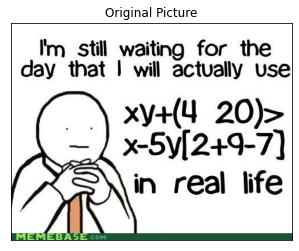

In [10]:
face_raw = Image.open("waiting.jpeg")
face = np.array(face_raw).astype(np.uint8)

plt.imshow(face_raw)
plt.xticks(())
plt.yticks(())
plt.title("Original Picture")
plt.show()

In [11]:
# Image is saved as a 3-dimensional array with shape H x W x C (heigt x width x channels)
Rf = face[:,:,0] - face[:,:,0].mean()
Gf = face[:,:,1] - face[:,:,1].mean()
Bf = face[:,:,2] - face[:,:,2].mean()

# Compute SVD and plot the singular values for different image channels
u, Rs, vh = np.linalg.svd(Rf, full_matrices=False)
u, Gs, vh = np.linalg.svd(Gf, full_matrices=False)
u, Bs, vh = np.linalg.svd(Bf, full_matrices=False)

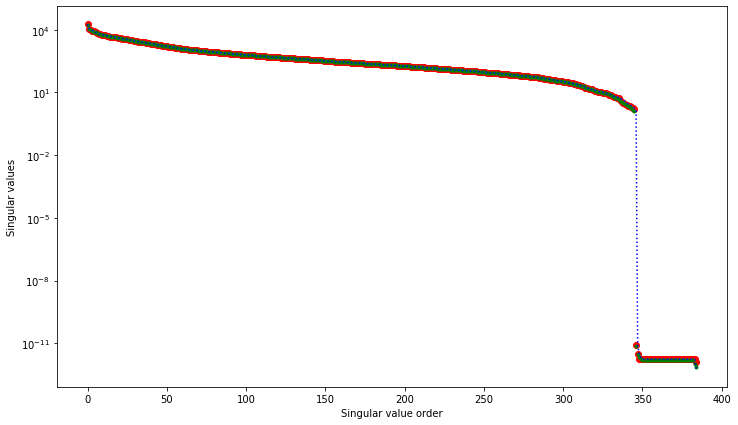

In [12]:
plt.figure(figsize=(12,7))
plt.plot(Rs,'ro')
plt.plot(Gs,'g.')
plt.plot(Bs,'b:')
plt.yscale('log')
plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.show()

## 2. Compress

Complete a function ```compress```, that performs SVD and truncates it (using $k$ singular values/vectors). See the prototype below. 

Note, that in case when your images are not grayscale you have to split your image to channels and work with matrices corresponding to different channels separately.

Plot approximate reconstructed image $M_\varepsilon$ of your favorite image such that $rank(M_\varepsilon) = 5, 20, 50$ using ```plt.subplots```.

In [19]:
def compress(image, k):
    """
    Perform svd decomposition and truncate it (using k singular values/vectors)
    
    Parameters: 
        image (np.array):        input image (probably, colourful)
        
        k (int):                 approximation rank
        
    --------
    Returns:
      reconst_matrix (np.array): reconstructed matrix (tensor in colourful case)
      
      s (np.array):              array of singular values 
    """
    image2 = image.copy()
    
    Rf = image2[:,:,0] - image2[:,:,0].mean(axis=1, keepdims=True)
    Gf = image2[:,:,1] - image2[:,:,1].mean(axis=1, keepdims=True)
    Bf = image2[:,:,2] - image2[:,:,2].mean(axis=1, keepdims=True)
    
    # compute per-channel SVD for input image
    # <your code here>
    u_r, Rs, vh_r = np.linalg.svd(Rf, full_matrices=False)
    u_g, Gs, vh_g = np.linalg.svd(Gf, full_matrices=False)
    u_b, Bs, vh_b = np.linalg.svd(Bf, full_matrices=False)
    Rs = Rs[:k]
    Gs = Gs[:k]
    Bs = Bs[:k]
    
    # reconstruct the input image with the given approximation rank
    # <your code here>
    red_channel = u_r[:, :k] @ np.diag(Rs) @ vh_r[:k, :]
    green_channel = u_g[:, :k] @ np.diag(Gs) @ vh_g[:k, :]
    blue_channel = u_b[:, :k] @ np.diag(Bs) @ vh_b[:k, :]
    
    reduced_im = np.stack([red_channel, green_channel, blue_channel], axis=2)
    
    # save the array of top-k singular values
    s = np.zeros((len(Gs), 3))
    # <your code here>
    s[:, 0] = Rs
    s[:, 1] = Gs
    s[:, 2] = Bs
    
    return reduced_im.copy(), s

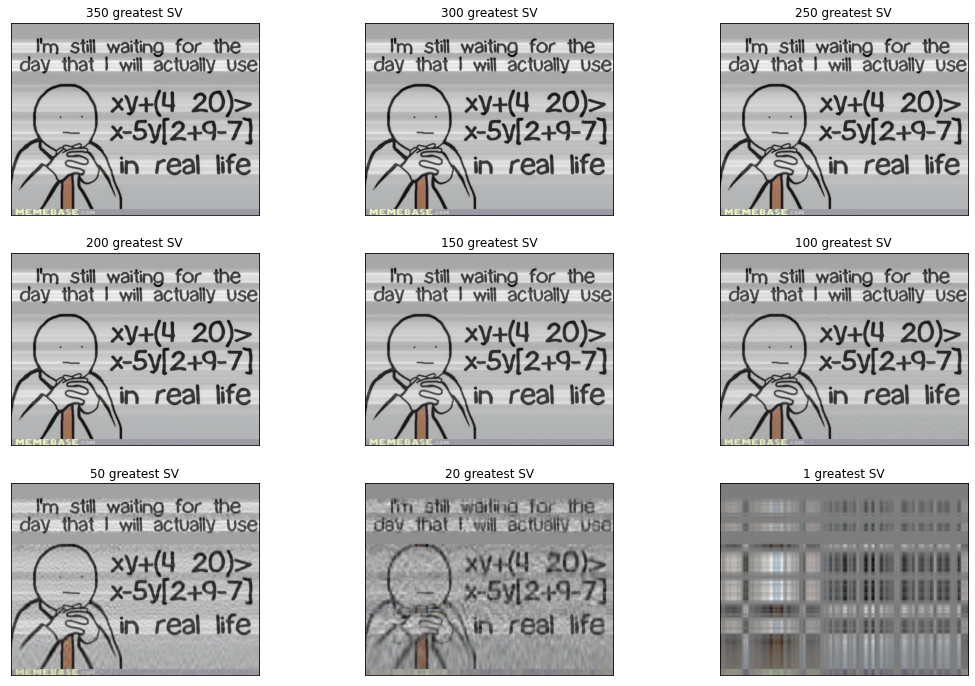

In [20]:
plt.figure(figsize=(18,12))
for i,k in enumerate([350,300,250,200,150,100,50,20,1]):
    plt.subplot(3,3,i+1)
    im,s = compress(face,k)
    plt.imshow((im-im.min())/(im.max()-im.min()))
    plt.xticks(())
    plt.yticks(())
    plt.title("{} greatest SV".format(k))

## 3. Discover

Plot the following two figures for your favorite picture
* How relative error of approximation depends on the rank of approximation?
* How compression rate in terms of storing information ((singular vectors + singular numbers) / total size of image) depends on the rank of approximation?

In [15]:
img, s = compress(face, k)

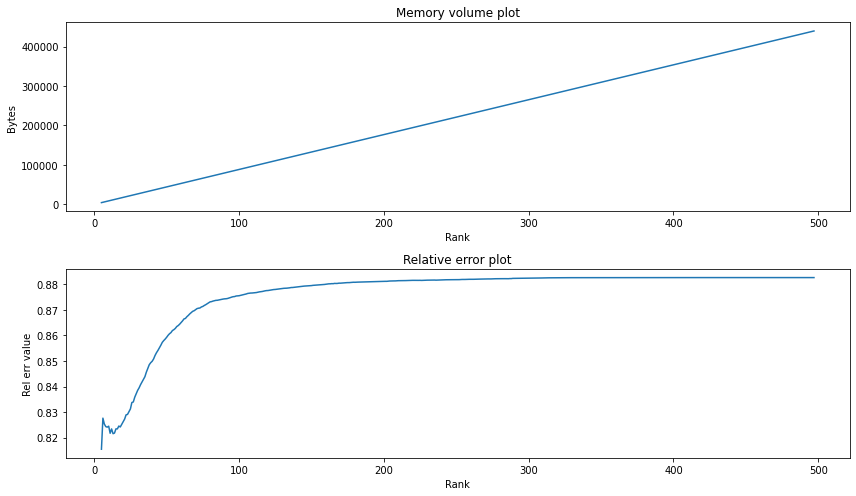

In [16]:
# fancy progress bar
from tqdm.auto import tqdm

k_list = range(5, face.shape[1], 1)
rel_err = []
info = []
for k in tqdm(k_list, leave=False):
    img, s = compress(face, k)
    
    current_relative_error = np.linalg.norm(img.astype(np.float64) - face.astype(np.float64))# MSE(img, face) / l2_norm(face)
    current_relative_error /= np.linalg.norm(face.astype(np.float64))
    current_information = k * (385 + 498 + 1) # U(image_height x K) @ S(diag KxK) @ V^T(K x image_width)
    
    rel_err.append(current_relative_error)
    info.append(current_information)
    
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.title("Memory volume plot")
plt.xlabel("Rank")
plt.ylabel("Bytes")
plt.plot(k_list, info)

plt.subplot(2,1,2)
plt.title("Relative error plot")
plt.xlabel("Rank")
plt.ylabel("Rel err value")
plt.plot(k_list, rel_err)

plt.tight_layout()
plt.show()

## 4. Compare

 Consider the following two pictures. Compute their approximations (with the same rank, or relative error). What do you see? Explain results.

In [17]:
image_raw1 = Image.open("../dataset/mipt.jpg")
image_raw2 = Image.open("../dataset/simpsons.jpg")

image1 = np.array(image_raw1).astype(np.uint8)
image2 = np.array(image_raw2).astype(np.uint8)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_raw1)
plt.title("One Picture")
plt.xticks(())
plt.yticks(())

plt.subplot(1, 2, 2)
plt.imshow(image_raw2)
plt.title("Another Picture")
plt.xticks(())
plt.yticks(())

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/mipt.jpg'

#### Same 

In [ ]:
# Your code is here
im1, s = compress(image1, 100)
im2, s = compress(image2, 100)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(Image.fromarray(im1, "RGB"))
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(Image.fromarray(im2, "RGB"))
plt.xticks(())
plt.yticks(())

plt.show()

#### Same relative error

In [ ]:
k_list = range(5,500,10)
rel_err1 = []
rel_err2 = []
relative_error_threshold = 0.15

for k in tqdm(k_list):
    image1_compressed, s = compress(image1, k)
    image2_compressed, s = compress(image2, k)
    
    relative_error_1 = np.linalg.norm(image1_compressed.astype(np.float64) - image1.astype(np.float64))
    relative_error_1 /= np.linalg.norm(image1.astype(np.float64))
    
    relative_error_2 = np.linalg.norm(image2_compressed.astype(np.float64) - image2.astype(np.float64))
    relative_error_2 /= np.linalg.norm(image2.astype(np.float64))
    
    rel_err1.append(relative_error_1)
    rel_err2.append(relative_error_2)

# find the indices
idx1 = int(np.argwhere(np.diff(np.sign(np.array(rel_err1) - relative_error_threshold))).flatten())
idx2 = int(np.argwhere(np.diff(np.sign(np.array(rel_err2) - relative_error_threshold))).flatten())
print("K1 = {}; K2 = {}".format(k_list[idx1], k_list[idx2]))

plt.figure(figsize=(12,7))

plt.plot(k_list[idx1], rel_err1[idx1], 'ro')
plt.plot(k_list[idx2], rel_err2[idx2], 'ro')
plt.title("Rel err for 2 pics")
plt.xlabel("Rank")
plt.ylabel("Rel error val")

plt.plot(k_list, rel_err1, label="Image 1")
plt.plot(k_list, rel_err2, label="Image 2")
plt.plot(k_list, [relative_error_threshold]*len(k_list),":",)

plt.legend()
plt.show()

In [ ]:
relative_error_threshold = 0.15

idx1 = int(np.argwhere(np.diff(np.sign(np.array(rel_err1) - relative_error_threshold))).flatten())
idx2 = int(np.argwhere(np.diff(np.sign(np.array(rel_err2) - relative_error_threshold))).flatten())

In [ ]:
image1_compressed, s = compress(image1, k_list[idx1])
image2_compressed, s = compress(image2, k_list[idx2])

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(Image.fromarray(image1_compressed, "RGB"))
plt.xticks(())
plt.yticks(())

plt.subplot(1,2,2)
plt.imshow(Image.fromarray(image2_compressed, "RGB"))
plt.xticks(())
plt.yticks(())
plt.show()